# Fine Tuning Open Ai

## **1. Instalación de librerías y carga de dependencias**

Se instalan las librerías esenciales:

* **transformers** y **datasets** para trabajar con modelos avanzados de lenguaje natural y conjuntos de datos compatibles con HuggingFace.
* **torch** para Deep Learning con PyTorch.
* Se importan utilidades para entrenamiento, optimización, manejo de datos, y visualización.

Esto permite trabajar tanto con modelos clásicos (entrenados localmente) como con APIs de modelos grandes (LLMs como GPT).

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

## **2. Carga de datos desde Google Drive**

Se monta Google Drive y se definen las rutas a los archivos de entrenamiento y validación, cargando los DataFrames con pandas.
Las columnas relevantes (`texto`, `etiqueta`) se normalizan y se crea una columna `label` necesaria para muchas APIs y formatos de entrenamiento.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#root_dir = "/content/drive/MyDrive/aaa/"
#root_dir = r"/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"
root_dir = r"/content/drive/MyDrive/PDG/data/"

path_df = root_dir + "train_oversample_df.xlsx"
path_train = root_dir + "train_oversample_df.xlsx"
path_test = root_dir + "val_df.xlsx"

In [ ]:
df_train = pd.read_excel(path_train)
df_train["label"] = df_train["etiqueta"]

In [ ]:
df_test = pd.read_excel(path_test)
df_test["label"] = df_test["etiqueta"]

In [ ]:
df_train

,texto,etiqueta,label
0,cardiopatia compleja. surcos y circunvolucione...,0,0
1,el paciente presenta un traumatismo craneoence...,1,1
2,cefalea surcos y circunvoluciones simetricos. ...,0,0
3,se sospecha de un accidente cerebrovascular - ...,1,1
4,"acv previo, trombocitopenia, anticoagulada con...",0,0
...,...,...,...
3378,desorientacion. prominencia de surcos y cisura...,0,0
3379,antecedente de tce: ahora confuso: a descartar...,0,0
3380,cefalea intensa en paciente anticoagulado. sur...,0,0
3381,cefalea. antecedente de hemorragia subaracnoid...,0,0


In [ ]:
df_test

,texto,etiqueta,label
0,ea- hta- dm- enfermedad coronaria- somnolencia...,0,0
1,"seguimiento postquirurgico, drenaje coleccion ...",1,1
2,antecedente de trauma craneal e inestabilidad ...,0,0
3,posible sindrome de demencial. prominencia de ...,0,0
4,asimetria facial y craneana.sinofris. surcos y...,0,0
...,...,...,...
654,cefalea en estudio. surcos y circunvoluciones ...,0,0
655,cefalea en estudio. surcos y circunvoluciones ...,0,0
656,"paciente con hemorragia subaracnoidea, descart...",1,1
657,nr la atenuacion del parenquima es normal para...,0,0


## **3. Preparación del dataset para fine-tuning en formato JSONL**

Se recorre el dataset de entrenamiento y para cada ejemplo se crea una estructura tipo chat con roles `"system"`, `"user"`, y `"assistant"`:

* **system**: Se define el comportamiento esperado del modelo (ser un especialista en radiología, decidir solo con el contenido, responder solo con 1 o 0).
* **user**: Contiene el texto real del informe radiológico.
* **assistant**: Contiene la etiqueta real (0 o 1).

Se almacena todo en formato **JSONL**, estándar para fine-tuning de modelos de lenguaje conversacional (como OpenAI GPT).
Este formato permite que el modelo aprenda no solo la tarea, sino también el contexto conversacional y la estructura de las instrucciones.

In [ ]:
concatenated_string_json = ""

for index, row in df_train.iterrows():
    # Limpia el texto
    clean_text = str(row["texto"]).replace("\n", " ").replace("\r", " ").replace('"', '\\"')
    label = str(row["label"]).replace('"', '\\"')

    concatenated_string_json += (
        f'{{'
        f'"messages": ['
        f'{{ "role": "system", "content": " '
        f'Eres un especialista en radiologia, y tienes que analizar el siguiente informe radiológico escrito en español y determinar si contiene hallazgos clínicos **críticos** que requieren atención médica urgente. '
        f'Un informe se considera crítico si describe condiciones potencialmente mortales, cambios agudos severos, o hallazgos que requieren una intervención inmediata. '
        f'No inventes ni asumas información adicional; basa tu decisión solo en el contenido del texto. '
        f'Responde estrictamente con un solo número: **1** si el informe es crítico, o **0** si no lo es. No añadas explicaciones ni comentarios." }} , '
        f'{{ "role": "user", "content": "{clean_text}" }}, '
        f'{{ "role": "assistant", "content": "{label}" }}'
        f']'
        f'}} \n'
    )


In [ ]:
with open('concatenated_string_json.jsonl', 'w') as f:
  f.write(concatenated_string_json)

---

## **4. Fine-tuning del modelo GPT con OpenAI**

* **Subida del archivo**: Se sube el archivo JSONL a OpenAI usando su API, estableciendo el propósito de fine-tuning.
* **Creación y monitoreo del trabajo de fine-tuning**: Se inicia el proceso de fine-tuning y se monitorea el progreso, mostrando eventos y el estado actual hasta que el modelo esté listo.
* **Listar trabajos y modelos resultantes**: Se pueden listar los últimos trabajos de fine-tuning y los modelos disponibles para inferencia, incluyendo los modelos fine-tuneados específicamente para tu tarea clínica.

## Finetunning

In [ ]:
import openai
openai.api_key = ""

In [ ]:
# Subir archivo jsonl for finetunning

response = openai.files.create(
    file=open("concatenated_string_json.jsonl", "rb"),
    purpose="fine-tune"
)
file_id = response.id
print("File uploaded:", file_id)


File uploaded: file-5fxMAEkFnxmAdCf1XcdmJ3


Iniciar el finetunning

In [ ]:
fine_tune_response = openai.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-3.5-turbo"
)
print("Fine-tune job started:", fine_tune_response.id)

Fine-tune job started: ftjob-JBXGZMskmrvK7dvrnPkRzPYr


In [ ]:
# Ver el estado del trabajo
status = openai.fine_tuning.jobs.retrieve(fine_tune_response.id)
print("Status:", status.status)

events = openai.fine_tuning.jobs.list_events(fine_tuning_job_id=fine_tune_response.id)
for event in events.data:
    print(event.message)

Status: validating_files
Validating training file: file-5fxMAEkFnxmAdCf1XcdmJ3
Created fine-tuning job: ftjob-JBXGZMskmrvK7dvrnPkRzPYr


## **5. Inferencia con el modelo fine-tuneado**

* Se define una función para consultar el modelo fine-tuneado dado un texto de informe. La función:

  * Usa las mismas instrucciones de contexto.
  * Envía el texto al modelo vía API.
  * Recupera la predicción (0 o 1) como respuesta determinista.
* Se aplica esta función a todo el conjunto de validación/test, generando las predicciones.

In [ ]:
fine_tune_id = fine_tune_response.id  # o coloca directamente el ID del fine-tune job

seen_event_ids = set()

print(f"⏳ Monitoreando el fine-tuning con ID: {fine_tune_id}\n")

while True:
    # Obtener el estado actual del trabajo
    status = openai.fine_tuning.jobs.retrieve(fine_tune_id)
    print(f"📌 Estado actual: {status.status}")

    # Obtener nuevos eventos
    events = openai.fine_tuning.jobs.list_events(fine_tuning_job_id=fine_tune_id).data
    events.reverse()  # Para mostrar los eventos en orden cronológico

    for event in events:
        if event.id not in seen_event_ids:
            print(f"[{event.created_at}] {event.message}")
            seen_event_ids.add(event.id)

    # Terminar si el fine-tuning finalizó
    if status.status in ["succeeded", "failed", "cancelled"]:
        print(f"\n✅ Fine-tuning finalizado con estado: {status.status}")
        break

    # Esperar antes de volver a consultar
    time.sleep(10)


⏳ Monitoreando el fine-tuning con ID: ftjob-JBXGZMskmrvK7dvrnPkRzPYr

📌 Estado actual: running
[1747406483] Step 158/1692: training loss=0.00
[1747406486] Step 159/1692: training loss=0.12
[1747406486] Step 160/1692: training loss=0.44
[1747406488] Step 161/1692: training loss=0.01
[1747406489] Step 162/1692: training loss=0.00
[1747406489] Step 163/1692: training loss=0.00
[1747406491] Step 164/1692: training loss=0.00
[1747406494] Step 165/1692: training loss=0.00
[1747406494] Step 166/1692: training loss=0.00
[1747406494] Step 167/1692: training loss=0.00
[1747406497] Step 168/1692: training loss=0.00
[1747406499] Step 169/1692: training loss=0.01
[1747406524] Step 170/1692: training loss=0.72
[1747406527] Step 171/1692: training loss=0.20
[1747406527] Step 172/1692: training loss=0.41
[1747406529] Step 173/1692: training loss=0.00
[1747406530] Step 174/1692: training loss=1.43
[1747406532] Step 175/1692: training loss=1.76
[1747406532] Step 176/1692: training loss=0.90
[1747406535]

In [ ]:
jobs = openai.fine_tuning.jobs.list(limit=10)

for job in jobs.data:
    print(f"ID: {job.id}")
    print(f"Estado: {job.status}")
    print(f"Modelo resultado: {job.fine_tuned_model}")
    print("----------")


ID: ftjob-JBXGZMskmrvK7dvrnPkRzPYr
Estado: succeeded
Modelo resultado: ft:gpt-3.5-turbo-0125:personal::BXr9Cyox
----------


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from openai import OpenAI
import time

# Initialize the OpenAI client
client = OpenAI(api_key="")

# Store model ID
model_id = "ft:gpt-4.1-mini-2025-04-14:spicichondaturo-organization:rad-alert:BTHGm3D8"

# Function to get model prediction for a single text
def get_prediction(text):
    try:
        response = client.responses.create(
            model=model_id,
            input=[
                {
                    "role": "system",
                    "content": [
                        {
                            "type": "input_text",
                            "text": (
                                "Eres un especialista en radiologia, y tienes que analizar el siguiente informe radiológico escrito en español y determinar si contiene hallazgos clínicos **críticos** que requieren atención médica urgente. "
                                "No inventes ni asumas información adicional; basa tu decisión solo en el contenido del texto. "
                                "Responde estrictamente con un solo número: **1** si el informe es crítico, o **0** si no lo es. No añadas explicaciones ni comentarios."
                            )
                        }
                    ]
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "input_text",
                            "text": text
                        }
                    ]
                }
            ],
            text={"format": {"type": "text"}},
            reasoning={},
            tools=[],
            temperature=0,  # Deterministic
            max_output_tokens=20,
            top_p=1,
            store=False
        )

        prediction = int(response.output[0].content[0].text)
        return prediction

    except Exception as e:
        print(f"Error with input: {text[:50]}... | Error: {e}")
        return None


In [ ]:
get_prediction(df_test['texto'].iloc[0])

0

In [ ]:
# Apply model to test dataframe
df_test['predicted'] = df_test['texto'].apply(lambda x: get_prediction(x))

No prestar atencion a esto

---

In [ ]:

# Optional: wait between calls to avoid rate limits
# time.sleep(1)

# Drop rows where prediction failed
df_test = df_test.dropna(subset=['predicted'])

# Calculate metrics
print("\nClassification Report:")
print(classification_report(df_test['etiqueta'], df_test['predicted'], digits=4))

print("Confusion Matrix:")
print(confusion_matrix(df_test['etiqueta'], df_test['predicted']))


Classification Report:
              precision    recall  f1-score   support

           0     0.9315    0.9907    0.9601       535
           1     0.9444    0.6855    0.7944       124

    accuracy                         0.9332       659
   macro avg     0.9380    0.8381    0.8773       659
weighted avg     0.9339    0.9332    0.9290       659

Confusion Matrix:
[[530   5]
 [ 39  85]]


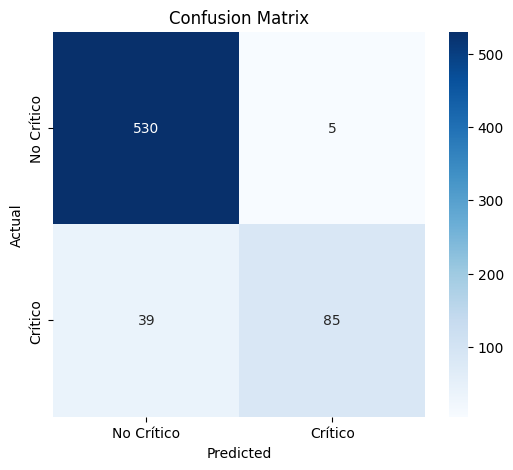

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(df_test['etiqueta'], df_test['predicted'])

# Optional: define class labels (adjust to your problem)
labels = ['No Crítico', 'Crítico']  # 0 = No crítico, 1 = Crítico

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


---
Ignore this

In [ ]:
concatenated_string_json = ""

for index, row in df_test.iterrows():
    # Limpia el texto
    clean_text = str(row["texto"]).replace("\n", " ").replace("\r", " ").replace('"', '\\"')
    label = str(row["label"]).replace('"', '\\"')

    concatenated_string_json += (
        f'{{'
        f'"messages": ['
        f'{{ "role": "system", "content": " '
        f'Eres un especialista en radiologia, y tienes que analizar el siguiente informe radiológico escrito en español y determinar si contiene hallazgos clínicos **críticos** que requieren atención médica urgente. '
        f'Un informe se considera crítico si describe condiciones potencialmente mortales, cambios agudos severos, o hallazgos que requieren una intervención inmediata. '
        f'No inventes ni asumas información adicional; basa tu decisión solo en el contenido del texto. '
        f'Responde estrictamente con un solo número: **1** si el informe es crítico, o **0** si no lo es. No añadas explicaciones ni comentarios." }} , '
        f'{{ "role": "user", "content": "{clean_text}" }}, '
        f'{{ "role": "assistant", "content": "{label}" }}'
        f']'
        f'}} \n'
    )


In [ ]:
with open('concatenated_string_json_test.jsonl', 'w') as f:
  f.write(concatenated_string_json)

In [ ]:
#show the first register of df_test show all the text
for index, row in df_test.iterrows():
    # Limpia el texto
    print(row["texto"])
    break

CEFALEA + ÉMESIS. La atenuación del parénquima es normal y no se observan masas ni desviación de las estructuras de la línea media.
El sistema ventricular no muestra alteraciones.
No hay evidencia de hemorragia intracraneana, infarto agudo, ni colecciones extra-axiales.
No se observan líneas de fractura.
Las porciones visualizadas de las orbitas y mastoides no muestran alteraciones. Engrosamiento mucoso en ambos senos maxilares, con presencia a nivel hidroaéreo en el seno maxilar derecho.
En la porción visualizada del cuello llama la atención heterogeneidad de la densidad de ambas glándulas parótidas, con microcalcificaciones, a correlacionar con antecedentes. Estudio sin evidencia de procesos patológicos agudos intracraneales.

Sinusopatía aguda maxilar derecha.


## **Data preparation and analysis for chat model fine-tuning**

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.3 MB/s eta 0:00:00


In [ ]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

In [ ]:
data_path = "concatenated_string_json.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 2701
First example:
{'role': 'system', 'content': ' Eres un especialista en radiologia, y tienes que analizar el siguiente informe radiológico escrito en español y determinar si contiene hallazgos clínicos **críticos** que requieren atención médica urgente. Un informe se considera crítico si describe condiciones potencialmente mortales, cambios agudos severos, o hallazgos que requieren una intervención inmediata. No inventes ni asumas información adicional; basa tu decisión solo en el contenido del texto. Responde estrictamente con un solo número: **1** si el informe es crítico, o **0** si no lo es. No añadas explicaciones ni comentarios.'}
{'role': 'user', 'content': 'EPISODIO CONVULSIVO. Llama la atención hiperdensidad del tentorio del cerebelo en el lado derecho sin identificar una clara imagen de hematoma o hemorragia.  Surcos y circunvoluciones simétricos.  Sistema ventricular de tamaño, configuración y densidad normales.  Línea media central.  Adecuada diferenciació

In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 16385 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 16,385 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 198, 1019
mean / median: 441.34727878563496, 431.0
p5 / p95: 303.0, 574.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 16,385 token limit, they will be truncated during fine-tuning


## **Cost Estimation**

In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 16385

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~1192079 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~3576237 tokens


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from openai import OpenAI
import time

# Initialize the OpenAI client
client = OpenAI(api_key="")

# Store model ID
model_id = "ft:gpt-4.1-mini-2025-04-14:spicichondaturo-organization:rad-alert:BTHGm3D8"

# Function to get model prediction for a single text
def get_prediction(text):
    try:
        response = client.responses.create(
            model=model_id,
            input=[
                {
                    "role": "system",
                    "content": [
                        {
                            "type": "input_text",
                            "text": (
                                "Eres un especialista en radiologia, y tienes que analizar el siguiente informe radiológico escrito en español y determinar si contiene hallazgos clínicos **críticos** que requieren atención médica urgente. "
                                "No inventes ni asumas información adicional; basa tu decisión solo en el contenido del texto. "
                                "Responde estrictamente con un solo número: **1** si el informe es crítico, o **0** si no lo es. No añadas explicaciones ni comentarios."
                            )
                        }
                    ]
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "input_text",
                            "text": text
                        }
                    ]
                }
            ],
            text={"format": {"type": "text"}},
            reasoning={},
            tools=[],
            temperature=0,  # Deterministic
            max_output_tokens=20,
            top_p=1,
            store=False
        )

        prediction = int(response.output[0].content[0].text)
        return prediction

    except Exception as e:
        print(f"Error with input: {text[:50]}... | Error: {e}")
        return None


## **6. Evaluación de desempeño**

* Se eliminan filas con predicciones nulas (por ejemplo, debido a errores en la API).
* Se calcula un **reporte de clasificación** (accuracy, precision, recall, F1-score) usando `sklearn`.
* Se genera la **matriz de confusión** y se visualiza con un mapa de calor (seaborn + matplotlib), permitiendo analizar visualmente los aciertos y errores del modelo (por ejemplo, falsos negativos o positivos).

In [ ]:
# Apply model to test dataframe
df_test['predicted'] = df_test['texto'].apply(lambda x: get_prediction(x))

# Optional: wait between calls to avoid rate limits
# time.sleep(1)

# Drop rows where prediction failed
df_test = df_test.dropna(subset=['predicted'])

# Calculate metrics
print("\nClassification Report:")
print(classification_report(df_test['etiqueta'], df_test['predicted'], digits=4))

print("Confusion Matrix:")
print(confusion_matrix(df_test['etiqueta'], df_test['predicted']))


Classification Report:
              precision    recall  f1-score   support

           0     0.9775    0.9838    0.9806       618
           1     0.8148    0.7586    0.7857        58

    accuracy                         0.9645       676
   macro avg     0.8962    0.8712    0.8832       676
weighted avg     0.9635    0.9645    0.9639       676

Confusion Matrix:
[[608  10]
 [ 14  44]]


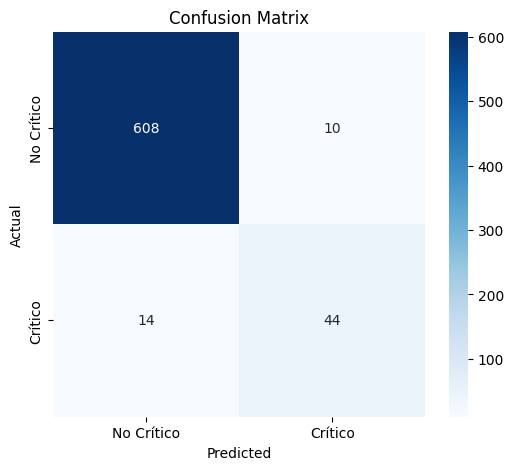

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(df_test['etiqueta'], df_test['predicted'])

# Optional: define class labels (adjust to your problem)
labels = ['No Crítico', 'Crítico']  # 0 = No crítico, 1 = Crítico

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
